In [1]:
import cv2
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
import numba
from numba import jit

In [3]:
from bbox_utils.bbox import generate_default_boxes

In [4]:
feature_map_shapes = [38, 19, 10, 5, 3, 1]

aspect_ratios = [
    [2, 0.5],
    [2, 3, 0.5, 0.333],
    [2, 3, 0.5, 0.333],
    [2, 3, 0.5, 0.333],
    [2, 0.5],
    [2, 0.5]
]
angles = [0, 45, 90, 135]

prior_boxes = generate_default_boxes(feature_map_shapes, 6, aspect_ratios, angles)

In [ ]:
np.array(prior_boxes[31038]) * 300

In [ ]:
def rotateTheta(x, y, theta):
    theta = theta * np.pi / 180

    x_rot_theta  = x * np.cos(theta) + y * np.sin(theta)
    y_rot_theta = y * np.cos(theta) - x * np.sin(theta)
    
    return x_rot_theta, y_rot_theta

def rotateRectangle(c_x, c_y, width, height, theta):

    rotRect = []
    
    corners = [
        [-width / 2, -height / 2],
        [width / 2, -height / 2],
        [width / 2, height / 2],
        [-width / 2, height / 2]
    ]
    
    for corner in corners:
        x_prime, y_prime = rotateTheta(corner[0], corner[1], theta)
        rotRect.append(c_x + x_prime)
        rotRect.append(c_y + y_prime)
    
    return rotRect

corners = rotateRectangle(0.5, 0.5, 0.2, 0.1, 90)

image = np.zeros((300, 300, 3))

corners = np.array(corners) * 300

print(corners)

corners = corners.astype(np.int32)

corners = corners.reshape(4, 2)

corners = corners.reshape((-1, 1, 2))

image = cv2.polylines(image, [corners],
                      True, (255, 100, 100), 1)
        
plt.figure(figsize=(10,10))

plt.imshow(image)

In [ ]:
np.array(prior_boxes[31038]) * 300

In [ ]:
def isRight(x1, y1, x2, y2, x, y):
    R = (x - x1) * (y2 - y1) - (y - y1) * (x2 - x1)
    
    return R >= 0

def calcSlopeIntercept(x1, y1, x2, y2):
    
    if x2 - x1 == 0:
        return float('inf'), x1
    
    m = ( y2 - y1 ) / ( x2 - x1 )
    
    b = y1 - m * x1
    
    return m, b

def findIntersectionInRange(m1, b1, m2, b2):
    if m1 == m2:
        return None, None
    
    elif m1 == float('inf'):
        x_intersect = b1
        y_intersect = m2 * x_intersect + b2
    elif m2 == float('inf'):
        x_intersect = b2
        y_intersect = m1 * x_intersect + b1
    elif m1 == 0:
        y_intersect = b1
        x_intersect = ( y_intersect - b2 ) / m2
    elif m2 == 0:
        y_intersect = b2
        x_intersect = ( y_intersect - b1 ) / m1
    else:
        x_intersect = (b2 - b1) / (m1 - m2)
        y_intersect = m1 * x_intersect + b1
    
    return [x_intersect, y_intersect]

# def clippedPolygon(subject, clip):
#     outputList = subject.copy()

#     for i in range(len(clip)):
#         inputList = outputList.copy()
#         outputList = []

#         curr_edge = clip[i]
#         prev_edge = clip[(i - 1) % len(clip)]

#         for j in range(len(inputList)):
#             curr_point = inputList[j]
#             prev_point = inputList[(j - 1) % len(inputList)]

#             m1, b1 = calcSlopeIntercept(prev_point[0], prev_point[1], curr_point[0], curr_point[1])
#             m2, b2 = calcSlopeIntercept(prev_edge[0], prev_edge[1], curr_edge[0], curr_edge[1])

#             interscecting_point = findIntersectionInRange(m1, b1, m2, b2)
#             if isRight(prev_edge[0], prev_edge[1], curr_edge[0], curr_edge[1], curr_point[0], curr_point[1]):
#     #             print(prev_edge[0], prev_edge[1], curr_edge[0], curr_edge[1], curr_point[0], curr_point[1])
#                 if not isRight(prev_edge[0], prev_edge[1], curr_edge[0], curr_edge[1], prev_point[0], prev_point[1]):
#                     outputList.append(interscecting_point)
#                 outputList.append([curr_point[0], curr_point[1]])
#             elif isRight(prev_edge[0], prev_edge[1], curr_edge[0], curr_edge[1], prev_point[0], prev_point[1]):
#                 outputList.append(interscecting_point)
#     return outputList

def clippedPolygon(subjectPolygon, subjectPolygonSize, clipPolygon, clipPolygonSize):
        
    newPolygon = np.empty( (16, 2), dtype=np.float64 )

    inputPolygon = np.empty( (16, 2), dtype=np.float64 )

    # copy subject polygon to new polygon and set its size
    for i in range(subjectPolygonSize):
        newPolygon[i] = subjectPolygon[i]

    newPolygonSize = subjectPolygonSize

    for j in range(clipPolygonSize):
        # copy new polygon to input polygon & set counter to 0
        for k in range(newPolygonSize):
            inputPolygon[k] = newPolygon[k]
        counter = 0

        # get clipping polygon edge
        cp1 = clipPolygon[j];
        cp2 = clipPolygon[(j - 1) % clipPolygonSize];

        for i in range(newPolygonSize):
            # get subject polygon edge
            s = inputPolygon[i];
            e = inputPolygon[(i - 1) % newPolygonSize];

    #         curr_edge = cp1
    #         prev_edge = cp2

    #         curr_point = s
    #         prev_point = e

            m1, b1 = calcSlopeIntercept(e[0], e[1], s[0], s[1])
            m2, b2 = calcSlopeIntercept(cp2[0], cp2[1], cp1[0], cp1[1])

            interscecting_point = findIntersectionInRange(m1, b1, m2, b2)

            if isRight(cp1[0], cp1[1], cp2[0], cp2[1], s[0], s[1]):
                if not isRight(cp1[0], cp1[1], cp2[0], cp2[1], e[0], e[1]):
                    newPolygon[counter] = interscecting_point
                    counter+=1
                newPolygon[counter] = [s[0], s[1]]
#                 newPolygon[counter][0] = s[0]
#                 newPolygon[counter][1] = s[1]
                counter+=1
            elif isRight(cp1[0], cp1[1], cp2[0], cp2[1], e[0], e[1]):
                newPolygon[counter] = interscecting_point
                counter+=1

        newPolygonSize = counter;
    return newPolygon[:newPolygonSize]
    

def shoelaceFormula(coordinates):
    if len(coordinates) < 3:
        return 'Not a polygon'
    
    area = 0

    for i in range(len(coordinates)):
        i_plus_1 = (i + 1) % len(coordinates)
        area += (coordinates[i_plus_1][0] * coordinates[i][1] - coordinates[i][0] * coordinates[i_plus_1][1]) / 2

    return abs(area)

In [ ]:
def getIOU(default_box, gt_box):
    default_box = np.array(default_box).reshape(4, 2)
    gt_box = np.array(gt_box).reshape(4, 2)
    
    clipped_polygon = clippedPolygon(default_box, len(default_box), gt_box, len(gt_box))
        
    if len(clipped_polygon) == 0:
        return 0
        
    default_box_area = shoelaceFormula(default_box)
    gt_box_area = shoelaceFormula(gt_box)
    clipped_polygon_area = shoelaceFormula(clipped_polygon)
    
    IOU = clipped_polygon_area / ( default_box_area + gt_box_area - clipped_polygon_area )
    
    return IOU

In [ ]:
default_box = [10, 50, 250, 50, 250, 290, 10, 290]

gt_box = [10, 10, 10, 270, 270, 270, 270, 10]

# Blue color in BGR
color = (255, 0, 0)
 
# Line thickness of 2 px
thickness = 1

image = np.zeros((300, 300, 3))

corners = np.array(default_box)
    
corners = corners.astype(np.int32)

corners = corners.reshape(4, 2)

corners = corners.reshape((-1, 1, 2))

image = cv2.polylines(image, [corners],
                      True, color, 1)

corners = np.array(gt_box)
    
corners = corners.astype(np.int32)

corners = corners.reshape(4, 2)

corners = corners.reshape((-1, 1, 2))

image = cv2.polylines(image, [corners],
                      True, color, 1)

plt.figure(figsize=(10,10))

plt.imshow(image)

In [ ]:
getIOU(default_box, gt_box)

In [ ]:
prior_boxes[31038]

In [ ]:
image = np.zeros((300, 300, 3))

corners = np.array(prior_boxes[31038]) * 300
    
corners = corners.astype(np.int32)

corners = corners.reshape(4, 2)

corners = corners.reshape((-1, 1, 2))

image = cv2.polylines(image, [corners],
                      True, color, 1)

plt.figure(figsize=(10,10))

plt.imshow(image)

In [ ]:
prior_boxes[31038]

In [ ]:
prior_boxes[31038]

gt_box = [0, 0, 0, 1, 1, 1, 1, 0]

getIOU(prior_boxes[31038], gt_box)

In [43]:
# Blue color in BGR
color = (255, 0, 0)
 
# Line thickness of 2 px
thickness = 1

image = np.zeros((300, 300, 3))
 
for i in np.arange(31038, 31039, 1):
    corners = np.array(prior_boxes[i]) * 300
    
    corners = corners.astype(np.int32)

    corners = corners.reshape(4, 2)
    
    corners = corners.reshape((-1, 1, 2))

    image = cv2.polylines(image, [corners],
                          True, color, 1)
    
gt_box = [0, 0, 1, 0, 1, 1, 0, 1]

corners = np.array(gt_box) * 300
    
corners = corners.astype(np.int32)

corners = corners.reshape(4, 2)

corners = corners.reshape((-1, 1, 2))

image = cv2.polylines(image, [corners],
                      True, color, 1)

overlap = [[0.08647853743729339, 0.88], [0.08647853743729339, 0.12], [0.9135214625627066, 0.12], [0.9135214625627066, 0.88]]

corners = np.array(overlap) * 300
    
corners = corners.astype(np.int32)

corners = corners.reshape((-1, 1, 2))

image = cv2.polylines(image, [corners],
                      True, (255, 100, 100), 1)

In [44]:
corners

array([[[ 25, 264]],

       [[ 25,  36]],

       [[274,  36]],

       [[274, 264]]], dtype=int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


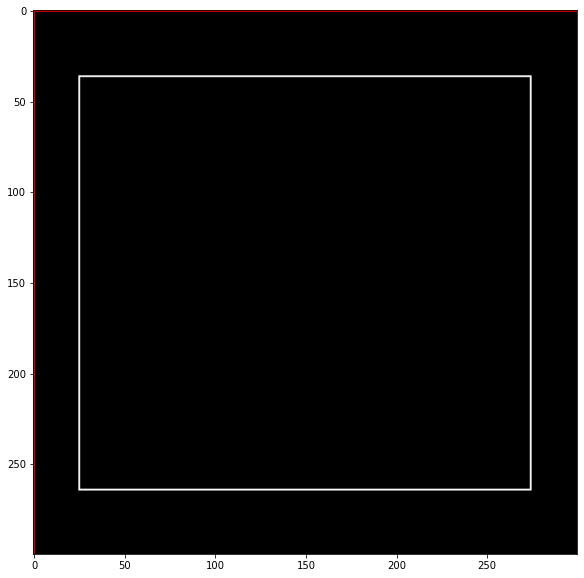

In [45]:
plt.figure(figsize=(10,10))

plt.imshow(image)

In [ ]:
prior_boxes[31038]

In [ ]:
gt_box

In [ ]:
prior_boxes[31038]

In [ ]:
np.array([[150, 100], [250, 200],[200, 250], [100, 150]]) / 300

In [47]:
image = np.zeros((300, 300, 3))

gt_box = [0.03333333, 0.16666667, 0.83333333, 0.16666667, 0.83333333,
       0.96666667, 0.03333333, 0.96666667]

gt_box = [0.5       , 0.33333333, 0.83333333, 0.66666667, 0.66666667, 0.83333333, 0.33333333, 0.5]

for i in range(len(prior_boxes)):
    
    iou = getIOU(prior_boxes[i], gt_box)
    
    if iou > 0.6:
    
        corners = np.array(prior_boxes[i]) * 300

        corners = corners.astype(np.int32)

        corners = corners.reshape(4, 2)

        corners = corners.reshape((-1, 1, 2))

        image = cv2.polylines(image, [corners],
                              True, color, 1)

        
corners = np.array(gt_box) * 300

corners = corners.astype(np.int32)

corners = corners.reshape(4, 2)

corners = corners.reshape((-1, 1, 2))

image = cv2.polylines(image, [corners],
                      True, (255, 100, 100), 1)
        
plt.figure(figsize=(10,10))

plt.imshow(image)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(float64, Literal[int](0))
 
There are 22 candidate implementations:
      - Of which 22 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(float64, int64)':
       No match.

During: typing of intrinsic-call at /var/folders/34/5ztskbx12m981d9v0q4821hh0000gn/T/ipykernel_12370/1574220204.py (72)
During: typing of static-get-item at /var/folders/34/5ztskbx12m981d9v0q4821hh0000gn/T/ipykernel_12370/1574220204.py (72)

File "../../../../var/folders/34/5ztskbx12m981d9v0q4821hh0000gn/T/ipykernel_12370/1574220204.py", line 72:
<source missing, REPL/exec in use?>

During: resolving callee type: type(CPUDispatcher(<function clippedPolygon at 0x12d26f9d0>))
During: typing of call at /var/folders/34/5ztskbx12m981d9v0q4821hh0000gn/T/ipykernel_12370/1574220204.py (106)

During: resolving callee type: type(CPUDispatcher(<function clippedPolygon at 0x12d26f9d0>))
During: typing of call at /var/folders/34/5ztskbx12m981d9v0q4821hh0000gn/T/ipykernel_12370/1574220204.py (106)


In [ ]:
np.array(prior_boxes[31038]) * 300

In [ ]:
image = np.zeros((300, 300, 3))

corners = np.array(prior_boxes[i]) * 300

corners = corners.astype(np.int32)

corners = corners.reshape(4, 2)

corners = corners.reshape((-1, 1, 2))

image = cv2.polylines(image, [corners],
                      True, color, 1)

corners = np.array(gt_box) * 300

corners = corners.astype(np.int32)

corners = corners.reshape(4, 2)

corners = corners.reshape((-1, 1, 2))

image = cv2.polylines(image, [corners],
                      True, color, 1)
        
plt.figure(figsize=(10,10))

plt.imshow(image)

In [ ]:
np.array([10, 50, 250, 50, 250, 290, 10, 290]) / 300

In [ ]:
getIOU(prior_boxes[i], gt_box)

In [ ]:
%%time

gt_box = [0.03333333, 0.16666667, 0.83333333, 0.16666667, 0.83333333,
       0.96666667, 0.03333333, 0.96666667]

for i in range(len(prior_boxes)):
    
    iou = getIOU(prior_boxes[i], gt_box)

In [ ]:
%%time

np.apply_along_axis(getIOU, 1, prior_boxes, gt_box)

In [48]:
@jit(nopython=True, parallel=False)
def isRight(x1, y1, x2, y2, x, y):
    R = (x - x1) * (y2 - y1) - (y - y1) * (x2 - x1)
    
    return R >= 0

@jit(nopython=True, parallel=False)
def calcSlopeIntercept(x1, y1, x2, y2):
        
    if x2 - x1 == 0:
        return 2**32 - 1, x1
    
    m = ( y2 - y1 ) / ( x2 - x1 )
    
    b = y1 - m * x1
    
    return np.float64(m), np.float64(b)

@jit(nopython=True, parallel=False)
def findIntersectionInRange(m1, b1, m2, b2):
    if m1 == m2:
        return np.array([2**32 - 1, 2**32 - 1], dtype=np.float64)
    
    elif m1 == 2**32 - 1:
        x_intersect = b1
        y_intersect = m2 * x_intersect + b2
    elif m2 == 2**32 - 1:
        x_intersect = b2
        y_intersect = m1 * x_intersect + b1
    elif m1 == 0:
        y_intersect = b1
        x_intersect = ( y_intersect - b2 ) / m2
    elif m2 == 0:
        y_intersect = b2
        x_intersect = ( y_intersect - b1 ) / m1
    else:
        x_intersect = (b2 - b1) / (m1 - m2)
        y_intersect = m1 * x_intersect + b1
    
    return np.array([x_intersect, y_intersect], dtype=np.float64)

@jit(nopython=True, parallel=False)
def clippedPolygon(subjectPolygon, subjectPolygonSize, clipPolygon, clipPolygonSize):
            
    newPolygon = np.empty( (16, 2), dtype=np.float64 )

    inputPolygon = np.empty( (16, 2), dtype=np.float64 )

    # copy subject polygon to new polygon and set its size
    for i in range(subjectPolygonSize):
        newPolygon[i] = subjectPolygon[i]

    newPolygonSize = subjectPolygonSize

    for j in range(clipPolygonSize):
        # copy new polygon to input polygon & set counter to 0
        for k in range(newPolygonSize):
            inputPolygon[k] = newPolygon[k]
        counter = 0

        # get clipping polygon edge
        cp1 = clipPolygon[j];
        cp2 = clipPolygon[(j - 1) % clipPolygonSize];

        for i in range(newPolygonSize):
            # get subject polygon edge
            s = inputPolygon[i];
            e = inputPolygon[(i - 1) % newPolygonSize];


            m1, b1 = calcSlopeIntercept(e[0], e[1], s[0], s[1])
            m2, b2 = calcSlopeIntercept(cp2[0], cp2[1], cp1[0], cp1[1])

            interscecting_point = findIntersectionInRange(m1, b1, m2, b2)

            if isRight(cp1[0], cp1[1], cp2[0], cp2[1], s[0], s[1]):
                if not isRight(cp1[0], cp1[1], cp2[0], cp2[1], e[0], e[1]):
                    newPolygon[counter] = interscecting_point
                    counter+=1
                newPolygon[counter] = [s[0], s[1]]
                counter+=1
            elif isRight(cp1[0], cp1[1], cp2[0], cp2[1], e[0], e[1]):
                newPolygon[counter] = interscecting_point
                counter+=1

        newPolygonSize = counter;
    return newPolygon[:newPolygonSize]

@jit(nopython=True, parallel=False)
def shoelaceFormula(coordinates):
    if len(coordinates) < 3:
        return np.float64(0)
    
    area = 0

    for i in range(len(coordinates)):
        i_plus_1 = (i + 1) % len(coordinates)
        area += (coordinates[i_plus_1][0] * coordinates[i][1] - coordinates[i][0] * coordinates[i_plus_1][1]) / 2

    return np.float64(area)

@jit(nopython=True, parallel=False)
def getIOU(default_box, gt_box):
    default_box = default_box.reshape(4, 2)
    
    
    
    clipped_polygon = clippedPolygon(default_box, len(default_box), gt_box, len(gt_box))
        
    if len(clipped_polygon) == 0:
        return 0
        
    default_box_area = shoelaceFormula(default_box)
    gt_box_area = shoelaceFormula(gt_box)
    clipped_polygon_area = shoelaceFormula(clipped_polygon)
    
    IOU = clipped_polygon_area / ( default_box_area + gt_box_area - clipped_polygon_area )
    
    return np.float64(IOU)

# Parallel version
@jit(nopython=True, parallel=True)
def getIOUOverallDefaultBox(prior_boxes, gt_box):
    gt_box = gt_box.reshape(4, 2)
    iou = np.empty(len(prior_boxes), dtype = np.float64)
    for i in numba.prange(len(prior_boxes)):
        iou[i] = getIOU(prior_boxes[i], gt_box)
        
    return iou

In [49]:
gt_box = [0.03333333, 0.16666667, 0.83333333, 0.16666667, 0.83333333,
       0.96666667, 0.03333333, 0.96666667]

gt_box = np.array(gt_box, dtype=np.float64)
prior_boxes= np.array(prior_boxes, dtype=np.float64)

getIOUOverallDefaultBox(prior_boxes, gt_box)

array([0.        , 0.        , 0.        , ..., 0.57439227, 0.54580721,
       0.58330925])

In [50]:
%%time
results = getIOUOverallDefaultBox(prior_boxes, gt_box)

CPU times: user 1.82 s, sys: 6.84 ms, total: 1.83 s
Wall time: 157 ms


In [51]:
results_mask = np.greater(results, 0.5)

In [56]:
np.where(np.any(results_mask, axis=0))

(array([0]),)

In [57]:
for i, mask in enumerate(results_mask):
    if mask:
        print(i)

30964
30965
30966
30967
30968
30969
30971
30973
30975
30977
31034
31035
31036
31037
31038
31039
31040
31041
31042
31043
31044
31045
31046
31047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


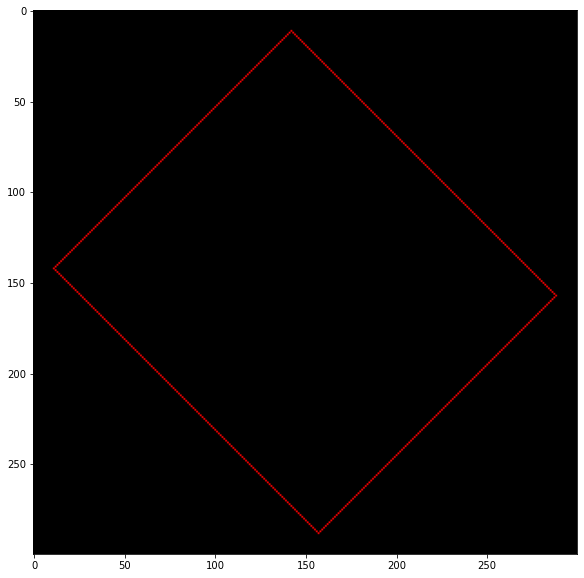

In [61]:
image = np.zeros((300, 300, 3))

corners = np.array(prior_boxes[30967]) * 300
    
corners = corners.astype(np.int32)

corners = corners.reshape(4, 2)

corners = corners.reshape((-1, 1, 2))

image = cv2.polylines(image, [corners],
                      True, color, 1)

plt.figure(figsize=(10,10))

plt.imshow(image)